# **Importaciónes generales**
**Importamos paquetes necesarios y los datos de Fashion MNIST, tambien se definen algunas funciones básicas del plot de imágenes y la de rounded accuracy para las métricas**

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd


# Seed para que las redes con iguales parametros no generen resultados aleatorios y siempre sean iguales
np.random.seed(42)
tf.random.set_seed(42)

# Para las graficas
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Función para plotear
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

#Función Rounded Accuracy
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

    
#Traemos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full_normalized = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full_normalized[:-5000], X_train_full_normalized[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#Función para ver los resultados de las reconstrucciones
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions,_ = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
#Función para visualziar multiples imagenes generadas por las GANs o VAEs        
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Sección 2.2**

2.2.1 Autoencoder regularizado usando convolucionales

**Definición y entrenamiento**

In [3]:
#Clear session para evitar que se guarde el entrenamiento por cada corrida del codigo, y volver a marcar la seed para evitar el factor aleatorio
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
#Early stop por si es necesario
#Early_stop=keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=3,verbose=1,restore_best_weights=True,start_from_epoch=150)

#Definicion del encoder con convolucionales 
conv_encoder = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Reshape([28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2)
])
#Definición del decoder con convolucionales
conv_decoder = keras.models.Sequential([
    keras.layers.Input(shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

#Definicion del autoencoder combinando el enconder y decoder ya definidos
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

#Se compila y entrena el modelo
conv_ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, 128,epochs=300,
                      validation_data=(X_valid, X_valid))#,callbacks=[Early_stop])


Epoch 1/300
 22/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.3332 - rounded_accuracy: 0.5250

I0000 00:00:1711823299.064173      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


430/430 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 3.7169 - rounded_accuracy: 0.5883 - val_loss: 2.1936 - val_rounded_accuracy: 0.7734
Epoch 2/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.8738 - rounded_accuracy: 0.8388 - val_loss: 1.1461 - val_rounded_accuracy: 0.8023
Epoch 3/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9799 - rounded_accuracy: 0.8824 - val_loss: 0.6343 - val_rounded_accuracy: 0.8041
Epoch 4/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5412 - rounded_accuracy: 0.8985 - val_loss: 0.3799 - val_rounded_accuracy: 0.8088
Epoch 5/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3235 - rounded_accuracy: 0.9097 - val_loss: 0.2491 - val_rounded_accuracy: 0.8482
Epoch 6/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2143 - rounded_accuracy: 0.9212 - val_loss: 0.1818 - val_rounded_accuracy: 0.8806
Epoch 7/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1576 - rounded_accuracy: 0.9298 - val_loss: 0.1433 - val_rounded_accuracy: 0.

KeyboardInterrupt: 

**Evolución del loss y accuracy**

In [ ]:
#Graficamos el loss de entrenamiento y de validación

plt.plot(history.history["loss"],label="Loss",figsize=(8, 5))
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0,0.05)
plt.legend()
plt.show()

In [ ]:
#Graficamos el accuracy de entrenamiento y el de validación

plt.plot(history.history["rounded_accuracy"],label="Accuracy",figsize=(8, 5))
plt.plot(history.history["val_rounded_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0.7,0.97)
plt.legend()
plt.show()

**Predicción y Visualización de resultados**

In [ ]:
#Usando la función definida se hace una predicción y se visualiza

show_reconstructions(conv_ae)
plt.show()

**Discusión**

* Los valores y convergencia del loss y accuracy son bastante satisfactorios, lo que se puede observar bien en las imagenes de la reconstrucción comparadas con las originales.

* Las gráficas de evolución del loss y accuracy muestran pocas fluctuaciones y una buena tendencia a la convergencia, lo que me lleva a resaltar una buena elección del optimizador y el learning rate.

* Tambíen probé con el pooling, cambiando de maxpooling a averagepooling, pero el resultado fue mejor en maxpooling, asi que en este caso favorece más el valor máximo que el promedio.

* Parámetros como el stride o el kernel size tambien pueden modificarse pero son más limitados por el tamaño requerido de las imagenes en el output, trate de modificarlo pero el mejor resultado fue siempre con kernel=3 y stride=2, cambiarlos dejando el mismo tamaño de output solo empeora el resultado de salida.

* Respecto a los tips de entrenamiento se pueden resaltar varias cosas:

    1. Si ubiera seguido con el optimizador SGD se podian ver resultados aceptables casi sin emplear ningún tip, y tampoco daba señales de overfitting, pero al cambiar a Adam los resultados sin emplear tips de entrenamiento eran muy malos, y SGD requeria un learning rate muy alto para converger a un resultado aceptable en menos de 300 epocas, tardando demasiado en la ejecución.
    2. Utilizando inicializadores y batch normalization Adam ya llegaba a algo, aunque seguia lejos de ser bueno, al menos se podía ver algun resultado de la predición, con mucho loss y poco accuracy.
    3. Ajustando el learning rate a un número inferior a 0.01, y utilizando regularizadores y dropout, pude darle 300 epocas a Adam para lograr el resultado final sin riesgo de overfitting. Lo más importante de esto fue el learning rate, con SGD un learning rate de 0.001 necesitaria unas 500 epocas para llegar al resultado que alcanzo Adam, pero sin los regularizadores ni el dropout el resulado no era bueno y corría riesgo de overfitting.
 
* Al final, con un loss de menos de 0.009 y un accuracy de más de 0.95, quedo conforme con el resultado del entrenamiento de la red.


2.2.2 Autoencoder Variacional

**Definición y Entrenamiento**

In [ ]:
#Definimos la función que crea el encoder
def build_encoder(latent_dim):
    encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(encoder_inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, activation='relu',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(50, activation='relu',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
#En lugar de tener una sola salida, el encoder tiene como salidas los valores necesarios para calcular la densidad de probabilidad
#en la nube del espacio latente
    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder

#Definimos la función que crea el decoder
def build_decoder(latent_dim):
    decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(1000, activation='relu',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(decoder_inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(7*7*64, activation='relu',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(decoder_inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='relu', padding='same')(x)
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder

#Esta clase se crea para introducir las propiedades del autoencode variacional, en particular el loss probabilistico
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
#La funcion call de la clase VAE calcula el loss por divergencia Kl usando los datos de salida del encoder, y luego los añade
#usado el metrodo add_loss
    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
#Esta funcion se usa en la función call para convertir las muestras del espacio latente en un conjunto continuo y diferenciable, y asi 
#el espacio latente se convierte en la nube de probabilidad
    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * .5) + z_mean

In [ ]:
#Luego de definir las funcions y la clase VAE, se crea y entrena el modelo
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 50
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
#Usamos la clase VAE para definir el modelo
vae = VAE(encoder, decoder)
#Compilamos y entrenamos
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse",metrics=[rounded_accuracy])
history=vae.fit(X_train, X_train, epochs=10, batch_size=64, validation_data=(X_valid, X_valid))

**Evolución del loss y el accuracy**

In [ ]:
#Graficamos el loss de entrenamiento y validación
plt.plot(history.history["loss"],label="Loss",figsize=(8, 5))
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0,0.05)
plt.legend()
plt.show()

In [ ]:
#Graficamos el accuracy de entrenamiento y el de validación

plt.plot(history.history["rounded_accuracy"],label="Accuracy",figsize=(8, 5))
plt.plot(history.history["val_rounded_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0.7,0.97)
plt.legend()
plt.show()

**Predicción y visualización de resultados**

In [ ]:
show_reconstructions(vae)
plt.show()

**Discusión**
* De momento usé los mismos tips que para el autoencoder con convolucionales, lo raro es que sin importar que parametros cambiara, solo logre mejorar la estabilidad de la convergencia de adam, no la calidad de las reconstrucciones en si, esta siempre fue igual. 
* La unica forma en que empeoró la reconstrucción fue multiplicando el kl_loss por un número, a manera de peso cuando un modelo tiene varias funciones loss, si ese número era menor a 0.8 no daba nada de reconstrucción, y más de 0.8 siempre daba el mismo resultado.

2.2.3 GANs

**Difinición y Entrenamiento**

In [ ]:
#Definimos la red GAN
#Seed para el factor aleatorio y clear para no conservar datos de entrenamientos previos
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#Esta variable marca el shape del input del generador
codings_size = 100

#Definimos el generador como un modelo secuencial
generator = keras.models.Sequential([
    keras.layers.InputLayer(shape=[codings_size]),
    keras.layers.Dense(7 * 7 * 128),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

#Definimos el discriminador como un modelo secuencial
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(shape=[28, 28, 1]),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

#Creamos el modelo GAN juntanto del generador y el discriminador
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
#Definimos una función para realizar el entrenamiento de la GAN considerando la competencia entre el generador y el discriminador
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=5):
    generator, discriminator = gan.layers
    #Para graficar el loss cree estas 2 listas
    discriminator_loss=[]
    generator_loss=[]
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for i_,X_batch in enumerate(dataset):
            print(f'\r{i_+1}/{round(X_train.shape[0]/X_batch.shape[0])}',end='')
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            #Guardo en una variable porque train_on_batch retorna el valor del loss para ese batch
            x=discriminator.train_on_batch(X_fake_and_real, y1)
            #Y ese valor guardado lo meto a la lista que va a usar para graficar el loss
            discriminator_loss.append(x)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            #Similar al discriminador, guardo el return de train_on_batch 
            x=gan.train_on_batch(noise, y2)
            #Y lo agrego a la lista de los losses para graficarlos
            generator_loss.append(x)
    #Ploteo 6 imagenes generadas pero solo al final para reducir el espacio usado por la celda de entrenamieno
    plot_multiple_images(generated_images, 6)
    plt.show()
    #Retorno las listas con los losses para hacer las gráficas
    return discriminator_loss,generator_loss

#Definimos el optimzador para customizar el learning rate
#Compilamos el discriminador para modificar su parametro trainable y que solo se entrene cuando se llame directamente su fit 
#o train_on_batch y no al entrenar el GAN completo, si se llama el fit de GAN solo se entrena el generador
optimizer=keras.optimizers.RMSprop(learning_rate=0.001)
discriminator.compile(loss="binary_crossentropy", optimizer="SGD")
discriminator.trainable = False
#Compilamos el GAN
gan.compile(loss="binary_crossentropy", optimizer=optimizer)

# Sección 2.3
**Clasificación y GradCAM+++**

In [2]:
#La primera vez tuve que instalar el paquete de vis, lo dejo porque no se se será necesario en todas las sesiones al reiniciar le kernel
#!pip install tf-keras-vis tensorflow --target=/kaggle/working/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 59.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 53.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.7 MB/s eta 0:00:00:00:01
   ━━━━

In [2]:
#importamos las librerias de vis par usar GradCAM++
import tf_keras_vis 
from tf_keras_vis.utils import num_of_gpus
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

#importamos la matriz de confuson para ver el resultado de la clasificación
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#Definimos una función para graficar la matriz de confusion
def show_classification(model, images=X_test):
    _,classification=model.predict(images)
    cm=confusion_matrix(y_test,classification.argmax(axis=1),normalize="true")
    disp=ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax)

#Esta parte solo muestra cuantas GPUs reconoce tensorflow
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 2 GPUs


**Modelo con clasificación**

In [31]:
#Antes de crear la instancia GradCAM++ es necesario definir el modelo con clasificación que se va a evaluar

#Clear session para evitar que se guarde el entrenamiento por cada corrida del codigo, y volver a marcar la seed para evitar el factor aleatorio
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
#Early stop por si es necesario
#Early_stop=keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=3,verbose=1,restore_best_weights=True,start_from_epoch=150)

#Número de clases para clasificar
class_num=10

#Definicion del encoder con convolucionales 

enc_input = keras.layers.Input(shape=[28, 28],name="Encoder_input")
x = keras.layers.Reshape([28, 28, 1])(enc_input)
x = keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.02))(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.02))(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.02))(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.BatchNormalization()(x)
enc_output = keras.layers.MaxPool2D(pool_size=2,name="Encoder_Output")(x)

#Definición del decoder con convolucionales

dec_input = keras.layers.Conv2DTranspose(32,name="Decoder_Input", kernel_size=3, strides=2, padding="VALID", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.02))(enc_output)
x = keras.layers.Dropout(rate=0.2)(dec_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.02))(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid")(x)
dec_output = keras.layers.Reshape([28, 28],name="Decoder_Output")(x)

#Definicion del Clasificador con densas
class_input = keras.layers.Flatten(name="class_input")(enc_output)
x = keras.layers.Dense(500,activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.02))(class_input)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(300,activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.02))(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(100,activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.02))(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.BatchNormalization()(x)
class_output = keras.layers.Dense(class_num,activation="softmax",name="class_output")(x)

#Definicion del autoencoder combinando el enconder, decoder y classificador ya definidos
conv_ae_class = keras.Model(inputs=enc_input,outputs=[dec_output,class_output])

#Definimos los pesos para las funciones loss
weight_mse=0.5

#Se compila y visualiza el modelo
conv_ae_class.compile(loss=["mse","sparse_categorical_crossentropy"],loss_weights=[weight_mse,1-weight_mse],optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                weighted_metrics=[["accuracy","mse"],["accuracy","sparse_categorical_crossentropy"]])
conv_ae_class.summary()
#tf.keras.utils.plot_model(conv_ae_class)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Encoder_input       │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 28, 28, 1) │          0 │ Encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        160 │ reshape[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 28, 28,    │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │         64 │ dropout[0][0]     │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 7, 7, 64)  │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Output      │ (None, 3, 3, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_input         │ (None, 576)       │          0 │ Encoder_Output[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 500)       │    288,500 │ class_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 500)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Input       │ (None, 7, 7, 32)  │     18,464 │ Encoder_Output[0… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 520,679 (1.99 MB)

 Trainable params: 518,559 (1.98 MB)

 Non-trainable params: 2,120 (8.28 KB)

In [32]:
#Se entrena el modelo
history = conv_ae_class.fit(X_train, [X_train,y_train], 64,epochs=300,
                      validation_data=(X_valid, [X_valid,y_valid]))#,callbacks=[Early_stop])

Epoch 1/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - Decoder_Output_accuracy: 0.0374 - Decoder_Output_mse: 0.1789 - class_output_accuracy: 0.5082 - class_output_sparse_categorical_crossentropy: 1.4748 - loss: 34.9535 - val_Decoder_Output_accuracy: 0.0567 - val_Decoder_Output_mse: 0.1089 - val_class_output_accuracy: 0.7342 - val_class_output_sparse_categorical_crossentropy: 0.8189 - val_loss: 12.8884
Epoch 2/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - Decoder_Output_accuracy: 0.0552 - Decoder_Output_mse: 0.0824 - class_output_accuracy: 0.7780 - class_output_sparse_categorical_crossentropy: 0.6133 - loss: 9.6974 - val_Decoder_Output_accuracy: 0.1428 - val_Decoder_Output_mse: 0.0830 - val_class_output_accuracy: 0.8186 - val_class_output_sparse_categorical_crossentropy: 0.5661 - val_loss: 4.0514
Epoch 3/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - Decoder_Output_accuracy: 0.0848 - Decoder_Output_mse: 0.0480 - class_output_accuracy: 0.8282 - class_output_sparse_categorical_crossent

**Evolución del loss y accuracy**

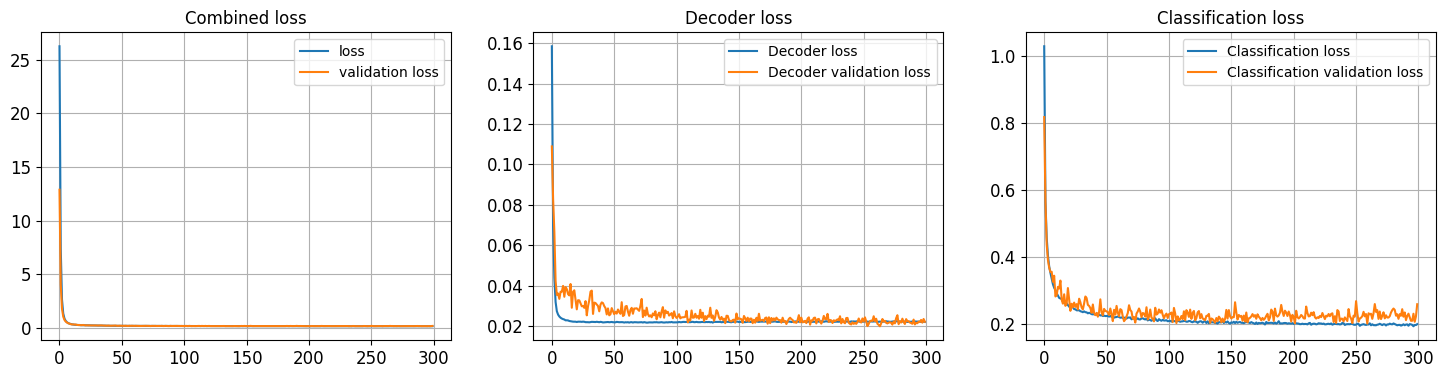

In [33]:
#Graficamos los diferentes loss

plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.title("Combined loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,2.5)
plt.legend()
plt.subplot(1,3,2)
plt.plot(history.history["Decoder_Output_mse"],label="Decoder loss")
plt.plot(history.history["val_Decoder_Output_mse"],label="Decoder validation loss")
plt.title("Decoder loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,2.5)
plt.legend()
plt.subplot(1,3,3)
plt.plot(history.history["class_output_sparse_categorical_crossentropy"],label="Classification loss")
plt.plot(history.history["val_class_output_sparse_categorical_crossentropy"],label="Classification validation loss")
plt.title("Classification loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,2.5)
plt.legend()
plt.show()

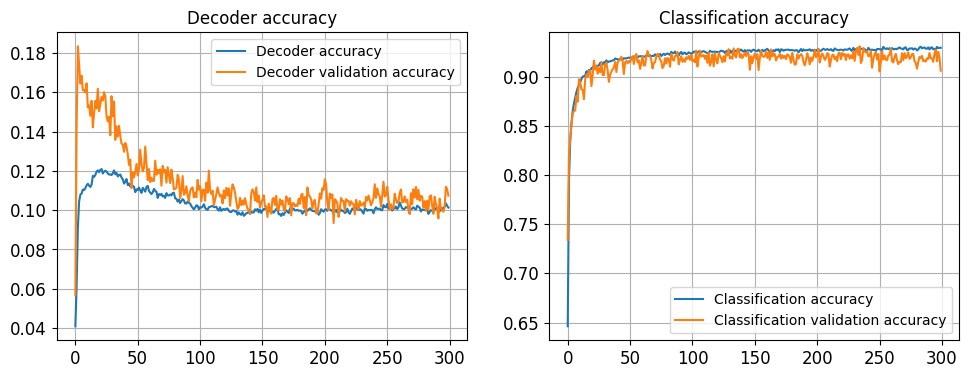

In [34]:
#Graficamos los diferentes accuracys

plt.figure(figsize=(18,4))

plt.subplot(1,3,1)
plt.plot(history.history["Decoder_Output_accuracy"],label="Decoder accuracy")
plt.plot(history.history["val_Decoder_Output_accuracy"],label="Decoder validation accuracy")
plt.title("Decoder accuracy")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,2.5)
plt.legend()
plt.subplot(1,3,2)
plt.plot(history.history["class_output_accuracy"],label="Classification accuracy")
plt.plot(history.history["val_class_output_accuracy"],label="Classification validation accuracy")
plt.title("Classification accuracy")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,2.5)
plt.legend()
plt.show()

**Predicción y Visualización de resultados**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


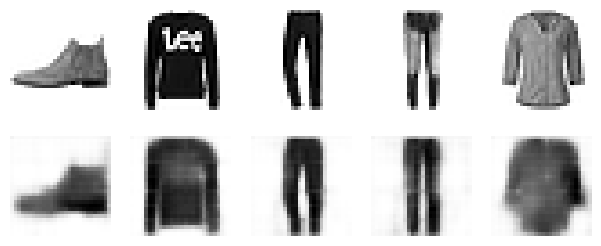

In [35]:
#visualizamos la reconstrucción en predicción
show_reconstructions(conv_ae_class)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


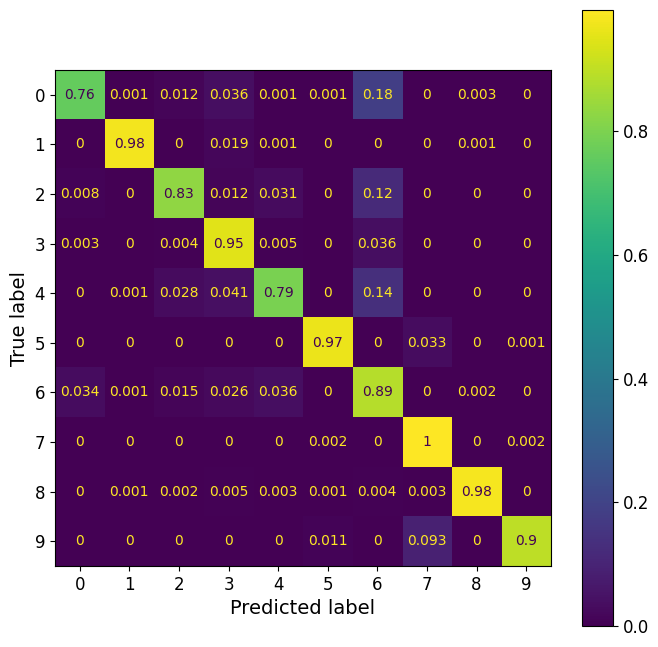

In [36]:
#Visualizamos la clasificación en predicción
show_classification(conv_ae_class)


**Implementación del GradCAM++**

**Pasos previos**

Creacion de variables y prueba

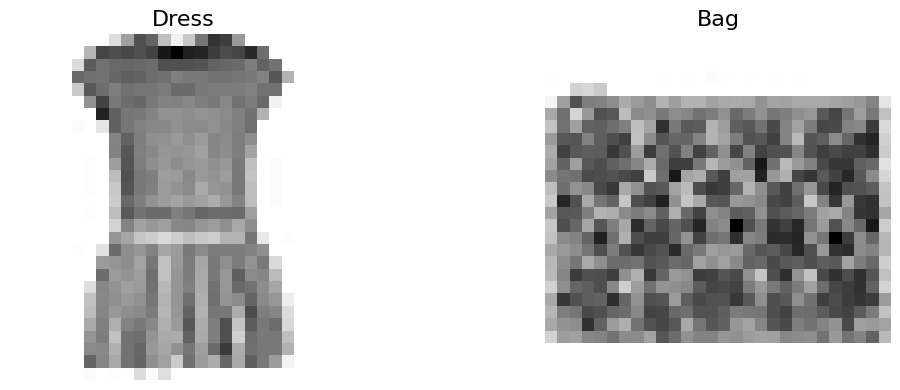

In [8]:
#Lo primero es definir las imagenes que se van a clasificar
#Les ponemos un título
img_titles=["Dress","Bag"]

#Extraemos las imagenes que queremos clasificar
#Primero un vestido
dress_index = None
for i, label in enumerate(y_train_full):
    if label == 3:  # 3 es el indice de la clase vestido
        dress_index = i
        break

# y guardamos la imagen en una variable
if dress_index is not None:
    dress_image = X_train_full[dress_index]

#Ahora lo mismo pero con un bolso
bag_index = None
for i, label in enumerate(y_train_full):
    if label == 8:  # 8 es el indice de la clase bolso
        bag_index = i
        break

# y guardamos la imagen en una variable
if bag_index is not None:
    bag_image = X_train_full[bag_index]
    
#Creamos un arreglo de numpy con las imagenes
images = np.asarray([np.array(dress_image), np.array(bag_image)])

# visualizamos las imagenes que vamos a utilizar
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, title in enumerate(img_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i],cmap="binary")
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**Definición del objeto GradCAM++**

In [ ]:
#Para una mejor resultado es mejor cambiar la activación de la capa visualizada a una lineal, para eso se usa 
#esta parte
replace2linear = ReplaceToLinear()

#Se debe definir una instancia con la cual darle un puntaje a la activación de los filtros al reconocer una imagen
#por eso se crea esta variable score
score=CategoricalScore([3,8])

#Luego de definir el modelo podemos crear el objeto GradCAM++
gradcam = GradcamPlusPlus(conv_ae_class,
                          model_modifier=replace2linear,
                          clone=True)

#Esta parte define el mapa de calor 
cam = gradcam(score,
              images,
              penultimate_layer=-1)

#Visualizar las imagenes y el mapa de calor
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()